## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
from numba import jit, njit, vectorize, cuda, int32, float32
import math
import numpy as np
import matplotlib.pyplot as plt


@vectorize([float32(int32)],target='parallel', fastmath=True)
def v_log(x):
    return math.log(x)

@vectorize([float32(int32)],target='parallel', fastmath=True)
def v_exp(x):
    c = math.exp(x)
    return c

A = [2,5,10,3,8]
print(v_log(A))
print(v_exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

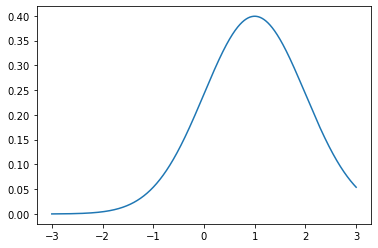

In [2]:
@jit
def gauss_prob(size):
    x = np.linspace(-3,3,size)
    y = (1/np.sqrt(2*np.pi))*np.exp(-((x-1)**2)/2)
    return y


plt.plot(np.linspace(-3,3,100000), gauss_prob(100000))
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

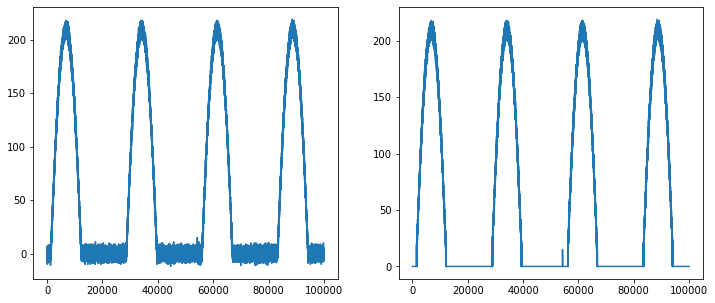

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here

@jit
def zeroSupp1(data, threshold):
    data[data<threshold] = 0
    return data

threshold = 15
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(data)
ax[1].plot(zeroSupp1(data, threshold))

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [4]:
x = np.random.rand(3,3)
y = np.random.rand(3,3)

@vectorize
def tanh_vec(argument):
    return math.tanh(argument)
@jit
def sigmoidKernel(x,y,alpha,c):
    arg = np.dot(alpha*x.T,y) + c 
    return tanh_vec(arg)

k = sigmoidKernel(x,y,1,4)
print(k)

[[0.99975203 0.99976746 0.99974839]
 [0.9997705  0.9996696  0.99959882]
 [0.9997815  0.99990345 0.99990851]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [5]:
@cuda.jit
def kernel_3d(matrix_3d):
    x, y, z = cuda.grid(3)
    if x < matrix_3d.shape[0] and y < matrix_3d.shape[1] and z < matrix_3d.shape[2]:
        matrix_3d[x, y, z] = math.cos(matrix_3d[x, y, z])

data = np.random.random((256, 256, 256))
        
threadsperblock = (16, 8, 4)
blockspergrid_x = int(np.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(np.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

kernel_3d[blockspergrid, threadsperblock](data)

print(data.shape)
print(data)

(256, 256, 256)
[[[0.7868892  0.90575996 0.74225953 ... 0.81130906 0.98556233 0.64397248]
  [0.76211398 0.9511781  0.98081767 ... 0.61258199 0.96358526 0.66779681]
  [0.98108349 0.9249374  0.82943685 ... 0.98664261 0.99596032 0.95896534]
  ...
  [0.70030902 0.79360139 0.99378569 ... 0.99576196 0.8356278  0.99286958]
  [0.97256397 0.69835527 0.73638121 ... 0.9294985  0.68139073 0.9728526 ]
  [0.86134568 0.99670415 0.99990215 ... 0.88295564 0.91646529 0.7344208 ]]

 [[0.9344614  0.82345983 0.68958964 ... 0.9994446  0.77575702 0.97546926]
  [0.56196005 0.93449302 0.91129329 ... 0.99625426 0.95251835 0.97330537]
  [0.56255871 0.97700634 0.99984188 ... 0.95144934 0.98415158 0.99891379]
  ...
  [0.931106   0.85345244 0.5833089  ... 0.97219666 0.94019765 0.82339147]
  [0.91590726 0.90633973 0.9954341  ... 0.73251612 0.7326614  0.95199598]
  [0.97952282 0.81524975 0.92423593 ... 0.99774308 0.60572728 0.91161989]]

 [[0.59067529 0.98744181 0.91404761 ... 0.63425304 0.99880574 0.54156279]
  [0.9

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [6]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(22, size=(24,12))
B = np.random.randint(22, size=(24,12))

# Configure the blocks
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((24,12))
matmul[blockspergrid, threadsperblock](A, B, C)

print(C)

[[1882. 1664. 1370. 1639. 1971. 1935. 1458. 1691. 1769. 1884. 2164. 1648.]
 [1643. 1398.  982. 1171. 1371. 1388. 1267. 1287. 1279. 1507. 1629. 1250.]
 [1620. 1529. 1176. 1237. 1473. 1758. 1137. 1643. 1435. 1867. 1781. 1400.]
 [1438. 1566. 1014. 1204. 1410. 1453. 1279. 1268. 1575. 1568. 1440. 1341.]
 [1387. 1521. 1015. 1086. 1387. 1389.  957. 1240. 1334. 1436. 1460. 1176.]
 [1235. 1050.  995. 1155. 1415. 1368.  910. 1024.  899. 1427. 1761. 1153.]
 [1451. 1623.  921. 1494. 1595. 1665.  950. 1277. 1326. 1740. 1783. 1456.]
 [1038. 1223.  657.  792. 1028. 1090.  773.  738. 1049. 1188. 1054. 1055.]
 [1571. 1642. 1034. 1501. 1768. 1867. 1125. 1420. 1362. 1814. 1870. 1326.]
 [1645. 1659. 1431. 1487. 1615. 1917. 1295. 1555. 1387. 1996. 2028. 1601.]
 [1708. 1424. 1241. 1524. 1650. 1678. 1206. 1204. 1395. 1590. 1806. 1364.]
 [1733. 1732. 1275. 1366. 1657. 1597. 1438. 1372. 1605. 1538. 1749. 1428.]
 [1618. 1703. 1363. 1329. 1745. 1859. 1250. 1281. 1388. 1881. 1969. 1535.]
 [1253. 1255.  864. 1184.